<a href="https://colab.research.google.com/github/Oussamalami/hands-on-2021/blob/main/Analyse_DPE_logement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>  Analyse de diagnostic de performance énérgétiques pour les logement par habitation <h1><center> 



Sujet

Vous travaillez au sein d'une direction Transition Énergétique développant des projets de rénovation énergétique des bâtiments et de développement d'énergies renouvelables. Que proposez-vous, sur la base entre-autres de ces données, pour permettre une meilleure exploitation et valorisation de celles-ci en vue d'alimenter les réflexions et les projets des collègues de la direction ?


Au sein de la direction de transition énergétique, le développement de projets de rénovation énergétique des bâtiments et le développement d’énergie renouvelables doit permettre l’amélioration de la performance énergétique des bâtiments qui a pour but de réduire la consommation globale d'énergie. Avant que toute mesure d'économie d'énergie du bâtiment ne soit prise, un processus d'évaluation et de diagnostic de la performance énergétique doit être mené pour identifier les zones de faible performance, la quantité d'utilisation d'énergie anormale et les causes probables. En amont de toutes ces phases de mesures prises pour développer des projets de rénovation il est important d’abord de traités les données à disposition, les analyser et puis faire une analyse globale sur le sujet.

Les enjeux liés à la rénovation énergétique nécessitent de disposer d’une bonne connaissance de la consommation énergétique des logements. Ainsi, cette exeercice présente une photographie de l'état du parc de l'ensemble des logements provenenant d'un échantillons des données issues de l'ADEME.

## I. Import Librairies

In [ ]:
!pip install ipython-autotime
%load_ext autotime
!pip install -U plotly
!pip install datapane

In [2]:
import warnings
warnings.filterwarnings('ignore')

time: 1.6 ms (started: 2022-02-16 08:11:39 +00:00)


In [4]:
#For data manipulation
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt 
import missingno as msno
import requests
import datapane as dp

time: 1.4 s (started: 2022-02-16 08:12:26 +00:00)


# II. Import Data

In [5]:
dff = pd.read_csv("/content/drive/MyDrive/Colab/76/76/td001_dpe-clean-geocoded.csv")

time: 4.01 s (started: 2022-02-16 08:12:49 +00:00)


## II. Exploratory Data Analysis (EDA) and prepocessing

Le suivi des objectifs de la France, ainsi que le pilotage de la politique en matière de rénovation énergétique, rendent nécessaire de correctement observer les performances énergétiques du parc de logement. Il est ainsi nécéssaire de mettre en œuvre une méthode exploitant correctement les données des diagnostics de performance énergétique (DPE), collectées par l’Ademe. 

Le nettoyage des données consiste à s'assurer que les données sont correctes, cohérentes et utilisables. Le but de cette première partie est d'identifier les erreurs ou les corruptions, en les corrigeant ou en les supprimant, ou en traitant manuellement les données si nécessaire pour éviter que les mêmes erreurs ne se produisent.

Cette partie réprésente un élément essentiel de la gestion des données afin de permettre une meilleur exploitation


## II. Nettoyage de notre DataFrame

###  Présentation des variables 

In [6]:
dff.head(5)

id     numero_dpe  ...  result_oldcity  result_district
0   98  1376V1000001D  ...             NaN              NaN
1  102  1376V1000002E  ...             NaN              NaN
2  294  1376V1000003F  ...             NaN              NaN
3  407  1376V1000004G  ...             NaN              NaN
4  543  1376V2000001E  ...             NaN              NaN

[5 rows x 84 columns]

time: 161 ms (started: 2022-02-16 08:13:05 +00:00)


In [7]:
dff.shape

(163619, 84)

time: 4.16 ms (started: 2022-02-16 08:13:09 +00:00)


In [9]:
test = pd.read_csv("71_commune_Rouen.csv",sep =';')

time: 5.77 ms (started: 2022-02-16 08:13:18 +00:00)


In [10]:
test.head(5)

Nom  Code_Insee
0                                Rouen       76540
1                Amfreville-la-Mi-Voie       76005
2                Anneville-Ambourville       76020
3  Les Authieux-sur-le-Port-Saint-Ouen       76039
4                          Bardouville       76056

time: 18.2 ms (started: 2022-02-16 08:13:20 +00:00)


In [11]:
test.rename(columns = {'Code_Insee': 'code_insee_commune_actualise'},inplace = True ) 

time: 2.23 ms (started: 2022-02-16 08:13:24 +00:00)


In [12]:
df2 = pd.merge(dff, test)  
print(df2.shape)


(43662, 85)
time: 897 ms (started: 2022-02-16 08:13:25 +00:00)


In [13]:
df2 = df2.drop([
                'result_label', 'result_score', 'result_type','result_id', 'result_housenumber', 
                'result_name', 'result_street','result_postcode', 'result_city', 'result_context', 
                'result_citycode','result_oldcitycode', 'result_oldcity', 'result_district'
                
                ], axis = 1) #'date_etablissement_dpe',

time: 67.8 ms (started: 2022-02-16 08:13:31 +00:00)


**Création d'une fonction qui permet d'observer le taux de remplissage pour chaque variables présente dans notre jeu de donnée. La droite Horizontale représente un seuil qui définit un taux de remplissage égale à 40%. On remarque qu'aucun point ne se situe en dessous de cette droite. La plupart de nos données sont complètes**

In [14]:
def calculateFillRate(df2):
  nbr_rows = len(df2.index)
  nbr_columns = len(df2.columns)
  fillRate = []
  for column in df2.columns:
    fillRate.append(100 * (nbr_rows - df2[column].isna().sum()) / nbr_rows)
  return fillRate

time: 4.15 ms (started: 2022-02-16 08:13:36 +00:00)


In [15]:
def showFillRate(df2):
  fillRate = calculateFillRate(df2)
  nbr_columns = len(df2.columns)
  x = np.linspace(0, nbr_columns, nbr_columns)
  y = fillRate
  z = [40 for i in range(nbr_columns)]
  plt.figure(figsize=(15,10))
  plt.scatter(x,y)

  plt.plot(x,z, color='red')
  plt.show()
  print(list(y))

time: 8.79 ms (started: 2022-02-16 08:13:37 +00:00)


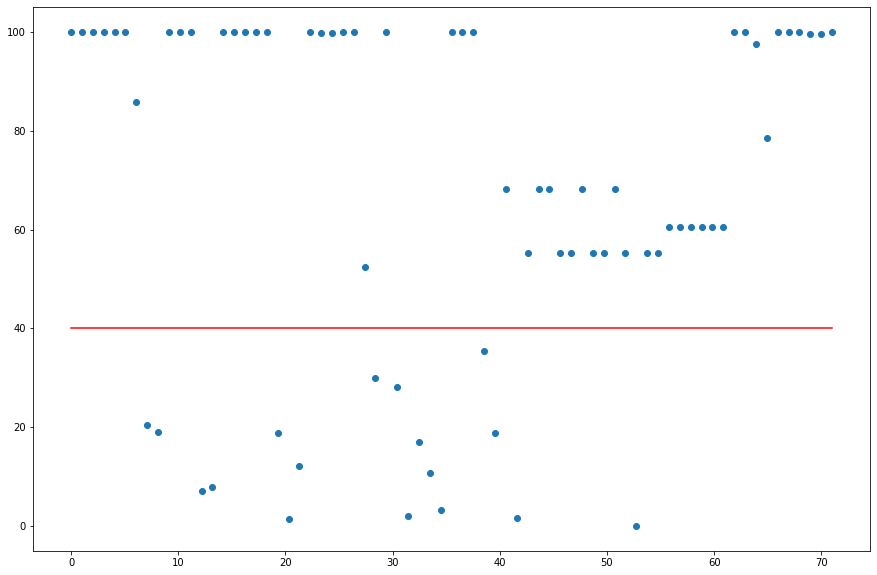

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 85.80688012459346, 20.399890064587055, 19.078374788145297, 100.0, 100.0, 100.0, 7.1618340891392975, 7.98405936512299, 100.0, 100.0, 100.0, 100.0, 100.0, 18.8081168979891, 1.4978700013741926, 12.08602446062938, 100.0, 99.78700013741927, 99.78700013741927, 100.0, 99.98625807338189, 52.34528880949109, 30.03069030278045, 99.99312903669095, 28.058723833081398, 2.111676056983189, 16.978150336677203, 10.821767211763088, 3.27515917731666, 100.0, 100.0, 100.0, 35.474783564655766, 18.897439421006826, 68.2057624478952, 1.566579634464752, 55.33873849113646, 68.2057624478952, 68.2057624478952, 55.3318675278274, 55.3318675278274, 68.2057624478952, 55.3318675278274, 55.3318675278274, 68.2057624478952, 55.3318675278274, 0.0, 55.3318675278274, 55.3318675278274, 60.56067060601897, 60.56067060601897, 60.56067060601897, 60.56067060601897, 60.56067060601897, 60.56067060601897, 100.0, 99.95419357793963, 97.45316293344327, 78.61985250332097, 100.0, 100.0, 100.0, 99.

In [16]:
showFillRate(df2)

In [17]:
percent_missing = df2.isnull().sum() * 100 / len(df2)
missing_values = pd.DataFrame({'column_name': df2.columns,
                                 'percent_missing': percent_missing})
missing_values

column_name  percent_missing
id                                        id         0.000000
numero_dpe                        numero_dpe         0.000000
usr_diagnostiqueur_id  usr_diagnostiqueur_id         0.000000
usr_logiciel_id              usr_logiciel_id         0.000000
tr001_modele_dpe_id      tr001_modele_dpe_id         0.000000
...                                      ...              ...
date_reception_dpe        date_reception_dpe         0.000000
concat-adress                  concat-adress         0.000000
latitude                            latitude         0.437451
longitude                          longitude         0.437451
Nom                                      Nom         0.000000

[71 rows x 2 columns]

time: 105 ms (started: 2022-02-16 08:13:50 +00:00)


In [18]:
missing_values.head(5)

column_name  percent_missing
id                                        id              0.0
numero_dpe                        numero_dpe              0.0
usr_diagnostiqueur_id  usr_diagnostiqueur_id              0.0
usr_logiciel_id              usr_logiciel_id              0.0
tr001_modele_dpe_id      tr001_modele_dpe_id              0.0

time: 14 ms (started: 2022-02-16 08:13:55 +00:00)


On affiche dans notre jeu de données les variables qui ont plus de 50% de valeurs manqauntes. J'ai décidé de les supprimer. A voir avc les équipes métiers

In [19]:
print(missing_values.loc[(missing_values['percent_missing'] > 50)])

                                                                           column_name  percent_missing
nom_methode_etude_thermique                                nom_methode_etude_thermique        79.600110
version_methode_etude_thermique                        version_methode_etude_thermique        80.921625
commentaires_ameliorations_recommandations  commentaires_ameliorations_recommandations        92.838166
explication_personnalisee                                    explication_personnalisee        92.015941
secteur_activite                                                      secteur_activite        81.191883
tr012_categorie_erp_id                                          tr012_categorie_erp_id        98.502130
tr013_type_erp_id                                                    tr013_type_erp_id        87.913976
type_voie                                                                    type_voie        69.969310
numero_rue                                                      

In [20]:
df2 = df2.drop([
                
                'nom_methode_etude_thermique','version_methode_etude_thermique','commentaires_ameliorations_recommandations',
                'explication_personnalisee','secteur_activite','type_voie','numero_rue','batiment',
                'escalier','etage','porte','numero_lot','surface_commerciale_contractuelle',
                'partie_batiment','type_vitrage_verriere','tr013_type_erp_id','tr012_categorie_erp_id'
                ], axis = 1) #'date_etablissement_dpe',

time: 15.9 ms (started: 2022-02-16 08:14:04 +00:00)


In [21]:
df2['latitude'].isna().sum()

191

time: 15.2 ms (started: 2022-02-16 08:17:39 +00:00)


In [22]:
df2.shape

(43662, 54)

time: 5.78 ms (started: 2022-02-16 08:17:41 +00:00)


In [23]:
df2 = df2[df2['latitude'].notna()]

time: 22 ms (started: 2022-02-16 08:17:44 +00:00)


In [ ]:
df2.shape

(43471, 54)

time: 3.8 ms (started: 2022-02-06 10:25:27 +00:00)


In [24]:
df2 = df2[df2['longitude'].notna()]

time: 19 ms (started: 2022-02-16 08:17:50 +00:00)


In [25]:
df2.shape

(43471, 54)

time: 3.62 ms (started: 2022-02-16 08:17:51 +00:00)


In [26]:
print(missing_values.loc[(missing_values['percent_missing'] < 50)])

                                                                                   column_name  percent_missing
id                                                                                          id         0.000000
numero_dpe                                                                          numero_dpe         0.000000
usr_diagnostiqueur_id                                                    usr_diagnostiqueur_id         0.000000
usr_logiciel_id                                                                usr_logiciel_id         0.000000
tr001_modele_dpe_id                                                        tr001_modele_dpe_id         0.000000
nom_methode_dpe                                                                nom_methode_dpe         0.000000
version_methode_dpe                                                        version_methode_dpe        14.193120
date_visite_diagnostiqueur                                          date_visite_diagnostiqueur         0

In [27]:
null_df = df2[[col for col in df2.columns if df2[col].isnull().any()]]

time: 78.8 ms (started: 2022-02-16 08:17:58 +00:00)


In [28]:
null_df.shape

(43471, 28)

time: 3.14 ms (started: 2022-02-16 08:18:00 +00:00)


In [29]:
null_df.columns

Index(['version_methode_dpe', 'surface_habitable', 'surface_thermique_lot',
       'commune', 'arrondissement', 'nom_rue', 'portee_dpe_batiment', 'shon',
       'surface_utile', 'surface_thermique_parties_communes', 'en_souterrain',
       'en_surface', 'nombre_niveaux', 'nombre_circulations_verticales',
       'nombre_boutiques', 'presence_verriere', 'surface_verriere',
       'nombre_entrees_avec_sas', 'nombre_entrees_sans_sas',
       'surface_baies_orientees_nord', 'surface_baies_orientees_est_ouest',
       'surface_baies_orientees_sud', 'surface_planchers_hauts_deperditifs',
       'surface_planchers_bas_deperditifs',
       'surface_parois_verticales_opaques_deperditives',
       'organisme_certificateur', 'adresse_organisme_certificateur',
       'dpe_vierge'],
      dtype='object')

time: 4.03 ms (started: 2022-02-16 08:18:01 +00:00)


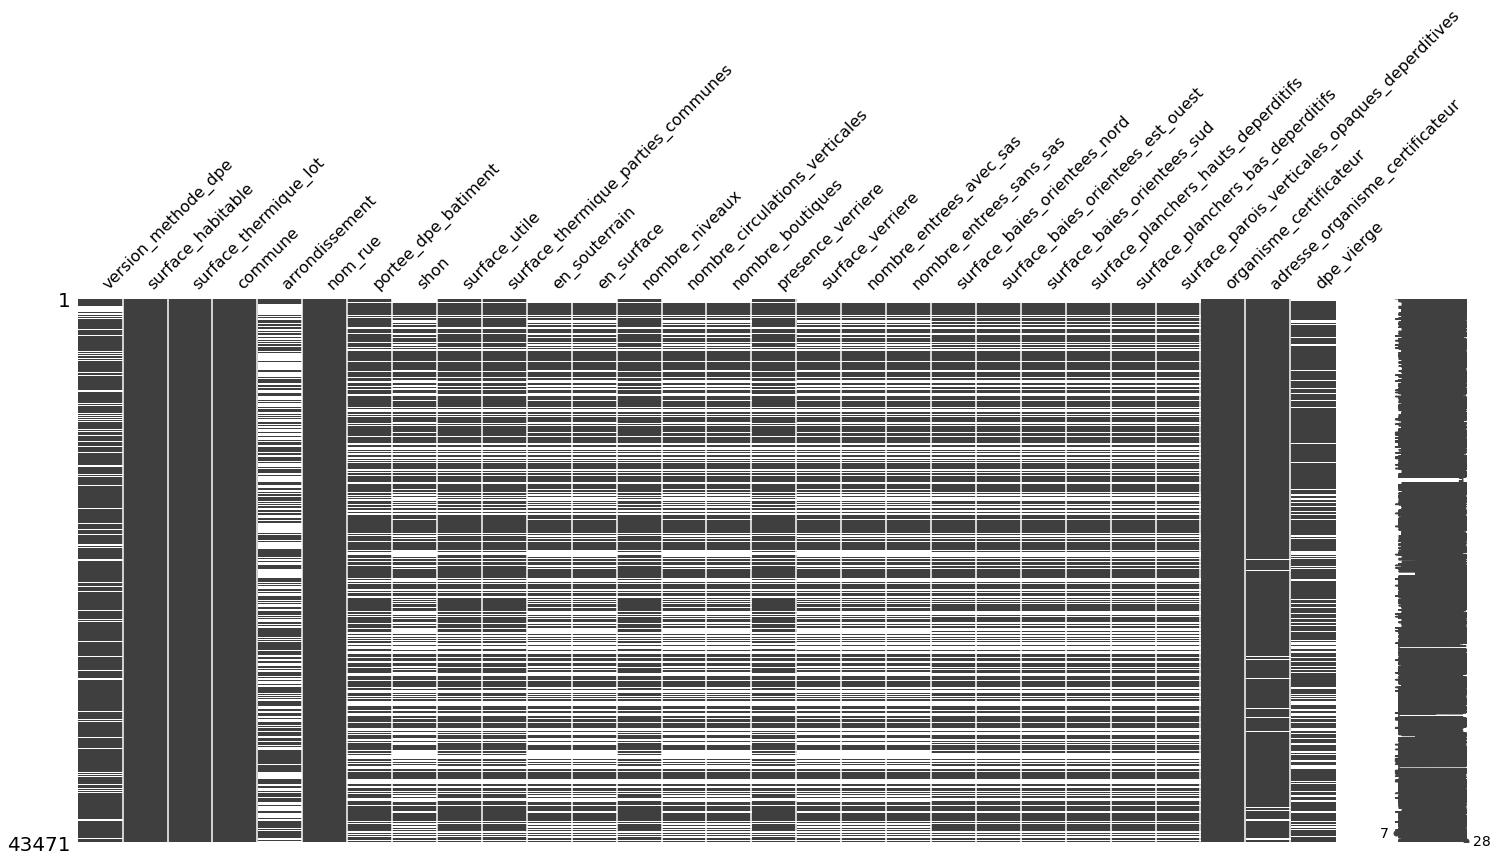

time: 2.06 s (started: 2022-02-06 10:26:02 +00:00)


In [ ]:
msno.matrix(null_df)

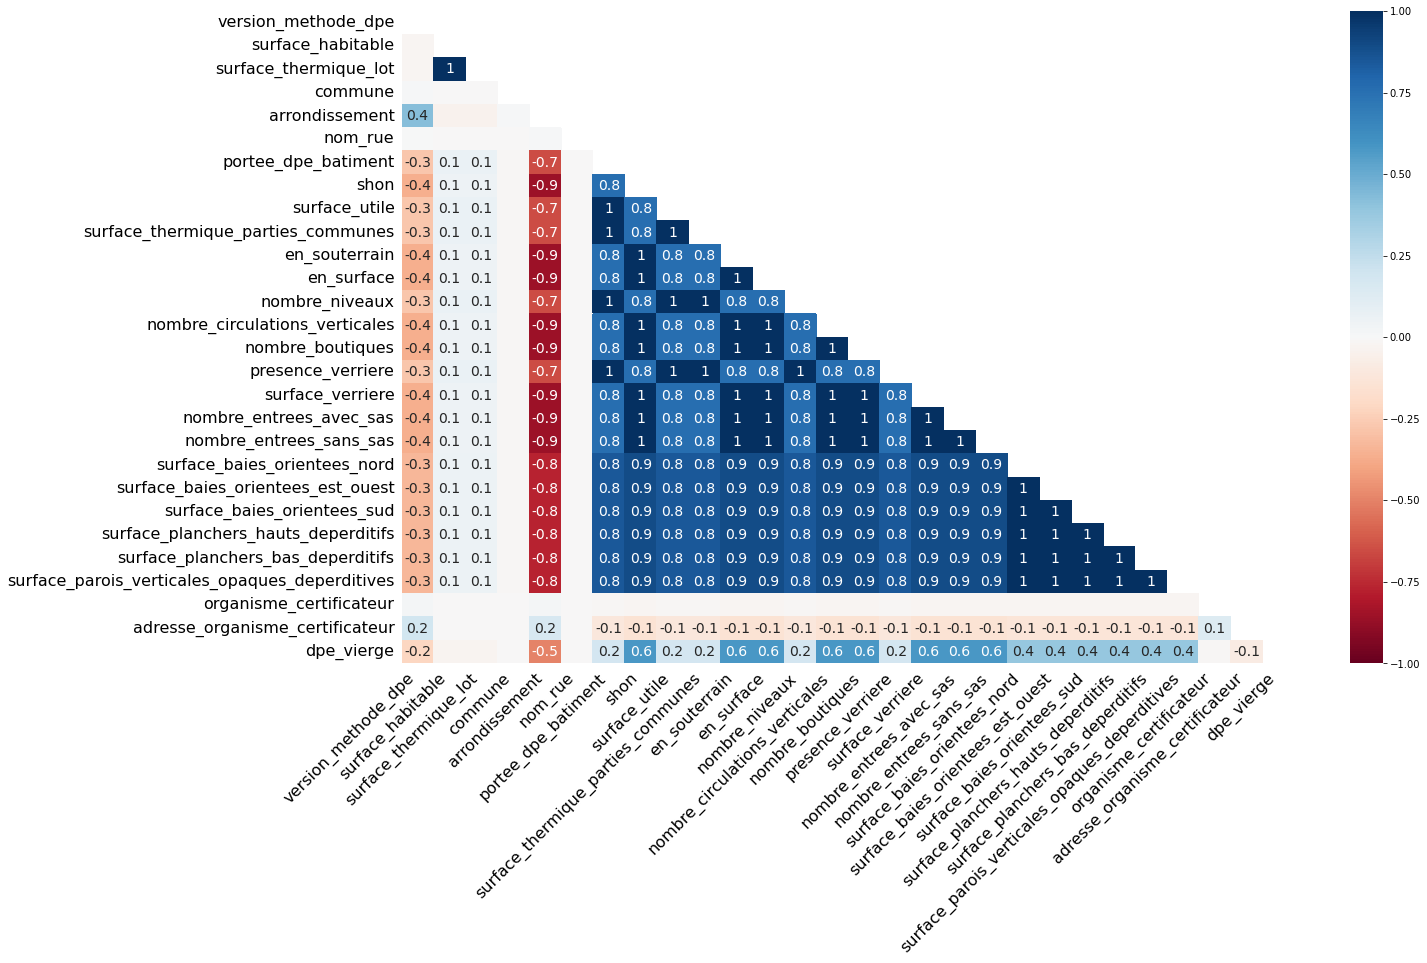

time: 2.61 s (started: 2022-02-06 10:26:10 +00:00)


In [ ]:
msno.heatmap(null_df)

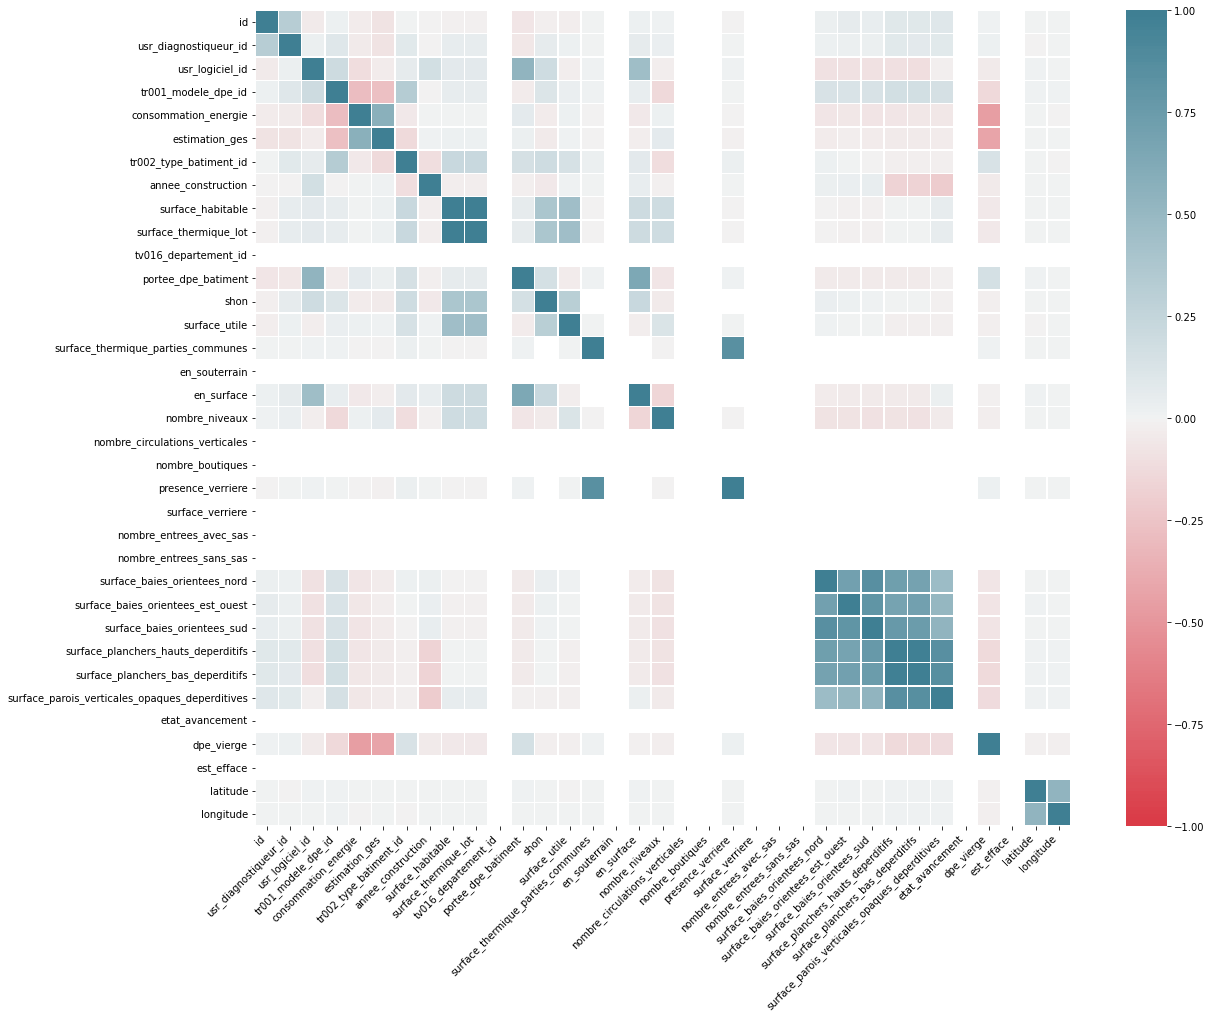

time: 1.49 s (started: 2022-02-06 10:26:19 +00:00)


In [ ]:
corr = df2.corr()

plt.subplots(figsize=(20,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 220, n=2000),
    square=True, linewidths=.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr

id  ...  longitude
id                                              1.000000  ...   0.004692
usr_diagnostiqueur_id                           0.325455  ...   0.001735
usr_logiciel_id                                -0.046107  ...   0.002338
tr001_modele_dpe_id                             0.020649  ...   0.012790
consommation_energie                           -0.035723  ...  -0.002573
estimation_ges                                 -0.081562  ...   0.004953
tr002_type_batiment_id                          0.005308  ...  -0.000642
annee_construction                             -0.007482  ...   0.006545
surface_habitable                              -0.012010  ...   0.000932
surface_thermique_lot                          -0.012010  ...   0.000932
tv016_departement_id                                 NaN  ...        NaN
portee_dpe_batiment                            -0.062822  ...   0.002298
shon                                           -0.023103  ...   0.001480
surface_utile                                  -0.026170  ...   0.000870
surface_thermique_parties_communes              0.004719  ...   0.000252
en_souterrain                                        NaN  ...        NaN
en_surface                                      0.019646  ...   0.000486
nombre_niveaux                                  0.010346  ...   0.003333
nombre_circulations_verticales                       NaN  ...        NaN
nombre_boutiques                                     NaN  ...        NaN
presence_verriere                              -0.001498  ...   0.000293
surface_verriere                                     NaN  ...        NaN
nombre_entrees_avec_sas                              NaN  ...        NaN
nombre_entrees_sans_sas                              NaN  ...        NaN
surface_baies_orientees_nord                    0.029257  ...   0.004535
surface_baies_orientees_est_ouest               0.060188  ...   0.005057
surface_baies_orientees_sud                     0.040611  ...   0.006860
surface_planchers_hauts_deperditifs             0.087200  ...   0.010200
surface_planchers_bas_deperditifs               0.086690  ...   0.009782
surface_parois_verticales_opaques_deperditives  0.095456  ...   0.009660
etat_avancement                                      NaN  ...        NaN
dpe_vierge                                      0.010061  ...  -0.016715
est_efface                                           NaN  ...        NaN
latitude                                        0.001353  ...   0.537322
longitude                                       0.004692  ...   1.000000

[35 rows x 35 columns]

time: 88.6 ms (started: 2022-02-06 10:26:27 +00:00)


In [30]:
df2.describe(percentiles= [.05,.10,.20, .30, .40, .50, .60, .70, .80, .90])

id  usr_diagnostiqueur_id  ...      latitude     longitude
count  4.347100e+04           43471.000000  ...  43471.000000  43471.000000
mean   4.706901e+06            9899.930735  ...     49.403574      1.066600
std    2.058597e+06            5043.064288  ...      0.604030      0.898932
min    1.436642e+06              12.000000  ...    -20.947282    -61.530142
5%     1.753588e+06            1252.000000  ...     49.287108      0.994352
10%    2.014673e+06            2210.000000  ...     49.305757      1.012511
20%    2.678733e+06            4380.000000  ...     49.389486      1.038928
30%    3.296618e+06            8031.000000  ...     49.411357      1.061627
40%    3.954332e+06            9467.000000  ...     49.425121      1.074028
50%    4.591701e+06            9591.000000  ...     49.432870      1.081837
60%    5.249175e+06           11834.000000  ...     49.441921      1.089218
70%    5.699447e+06           12854.000000  ...     49.445910      1.095755
80%    6.430961e+06           13410.000000  ...     49.454266      1.104443
90%    7.612318e+06           17046.000000  ...     49.471960      1.131257
max    9.039592e+06           21935.000000  ...     50.685334     55.288895

[15 rows x 35 columns]

time: 198 ms (started: 2022-02-16 08:18:31 +00:00)


### Visualisation de la colonne anne_construction pour observer les valeurs aberrantes

In [31]:
fig = px.box(df2, y="annee_construction")
fig.show(renderer="colab")

time: 669 ms (started: 2022-02-16 08:18:41 +00:00)


In [32]:
fig = px.histogram(df2, x="annee_construction")
fig.show(renderer="colab")

time: 300 ms (started: 2022-02-16 08:18:53 +00:00)


     Il y a une vague de construction dans les années 1940, probablement après la fin de la Seconde Guerre mondiale.
     Il existe de nombreuses valeurs déraisonnables. Regardons les années avant 1500 et après 2020 : 

In [33]:
df2[(df2['annee_construction'] > 2020) | (df2['annee_construction'] < 1500) ].shape

(940, 54)

time: 8.96 ms (started: 2022-02-16 08:21:48 +00:00)


In [34]:
df2[( df2['annee_construction'] < 2020) & (df2['annee_construction'] > 1500)]['annee_construction'].median()

1974.0

time: 30.6 ms (started: 2022-02-16 08:22:05 +00:00)


In [35]:
df2.loc[((df2.annee_construction < 1500) | (df2.annee_construction > 2020 )),'annee_construction'] = df2.loc[((df2.annee_construction > 1500)
 & (df2.annee_construction < 2020 )),'annee_construction'].median()

time: 8.41 ms (started: 2022-02-16 08:22:13 +00:00)


In [36]:
fig = px.histogram(df2, x="annee_construction")
fig.show(renderer="colab")

time: 299 ms (started: 2022-02-16 08:22:17 +00:00)


Pour calculer l'âge de chaque bâtiment au moment de la visite, nous devrons extraire l'année de visite d'une colonne différente puisque chaque colonne a quelques valeurs décalées, mais d'autres colonnes compensent cela. 

In [ ]:
df2['annee_visite'] = df2.apply(lambda row: int(row['date_visite_diagnostiqueur'][:4])
 if int(row['date_visite_diagnostiqueur'][:4]) >2000 and int(row['date_visite_diagnostiqueur'][:4]) <2020
else int(row['date_etablissement_dpe'][:4]), axis=1)

time: 887 ms (started: 2022-02-06 10:27:12 +00:00)


In [39]:
df2['date_etablissement_dpe']

0        2014-10-15
1        2014-10-15
2        2014-10-15
3        2014-10-15
4        2014-10-15
            ...    
43657    2017-09-29
43658    2017-10-06
43659    2017-09-13
43660    2017-10-24
43661    2018-04-06
Name: date_etablissement_dpe, Length: 43471, dtype: object

time: 17.4 ms (started: 2022-02-16 08:24:13 +00:00)


In [38]:
df2['date_visite_diagnostiqueur']

0        2014-10-15
1        2014-10-15
2        2014-10-13
3        2014-10-01
4        2014-10-15
            ...    
43657    2017-09-29
43658    2017-10-06
43659    2017-09-13
43660    2017-10-24
43661    2018-04-06
Name: date_visite_diagnostiqueur, Length: 43471, dtype: object

time: 19 ms (started: 2022-02-16 08:23:06 +00:00)


In [40]:
df2['annee_visite'] = df2.apply(lambda row: int(row['date_visite_diagnostiqueur'][:4])
 if int(row['date_visite_diagnostiqueur'][:4]) >2000 and int(row['date_visite_diagnostiqueur'][:4]) <2020 and int(row['date_visite_diagnostiqueur'][:4])<int(row['date_etablissement_dpe'][:4])
 else int(row['date_etablissement_dpe'][:4]), axis=1)

time: 1.31 s (started: 2022-02-16 08:25:35 +00:00)


In [41]:

df2['annee_visite'].max()

2019

time: 4.83 ms (started: 2022-02-16 08:25:38 +00:00)


In [43]:
df2['annee_visite'].value_counts()

2017    9983
2016    9118
2015    8265
2018    7712
2019    6171
2014    2131
2013      88
2000       2
2012       1
Name: annee_visite, dtype: int64

time: 8.46 ms (started: 2022-02-16 08:26:28 +00:00)


In [44]:
fig = px.histogram(df2, x="annee_visite")
fig.show(renderer="colab")

time: 187 ms (started: 2022-02-16 08:26:33 +00:00)


In [45]:
df2['age'] = df2['annee_visite'] - df2['annee_construction']

time: 3.58 ms (started: 2022-02-16 08:28:14 +00:00)


In [46]:
df2['age'].describe()

count    43471.000000
mean        36.909158
std         27.456678
min         -3.000000
25%         10.000000
50%         41.000000
75%         68.000000
max        416.000000
Name: age, dtype: float64

time: 14.3 ms (started: 2022-02-16 08:28:15 +00:00)


In [47]:
df2.loc[df2['age']<0,'age'].value_counts()

-1    46
-2     3
-3     1
Name: age, dtype: int64

time: 7.24 ms (started: 2022-02-16 08:28:31 +00:00)


Après examen des valeurs d'âge négatives, les valeurs -1 sont dues à un an d'écart entre la visite et l'établissement du bilan énergétique. Nous remplacerons le -1 par 0. Il en va de même pour l'âge '-4' comme pour le reste des valeurs négatives, nous n'avons pas pu leur donner de sens, nous allons donc supprimer ces lignes. 

In [48]:
df2.loc[(df2['age']==-1) | (df2['age']==-4), 'age'] = 0

time: 4.81 ms (started: 2022-02-16 08:29:18 +00:00)


In [49]:
df2.drop(df2.loc[df2['age'] < 0 ].index, inplace = True)

time: 24.7 ms (started: 2022-02-16 08:29:20 +00:00)


In [50]:
fig = px.histogram(df2, x="age")
fig.show(renderer="colab")

time: 315 ms (started: 2022-02-16 08:29:28 +00:00)


#### ***'surface_habitable'***
* Next, let's look at ***'surface_habitable'*** :

In [51]:
df2['surface_habitable'].describe()

count    43374.000000
mean       135.938553
std        437.398943
min          0.000000
25%         47.662500
50%         69.000000
75%         94.047500
max      27844.300000
Name: surface_habitable, dtype: float64

time: 13.2 ms (started: 2022-02-16 08:29:41 +00:00)


In [52]:
df2.columns

Index(['id', 'numero_dpe', 'usr_diagnostiqueur_id', 'usr_logiciel_id',
       'tr001_modele_dpe_id', 'nom_methode_dpe', 'version_methode_dpe',
       'date_visite_diagnostiqueur', 'date_etablissement_dpe',
       'date_arrete_tarifs_energies', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'tr002_type_batiment_id', 'annee_construction',
       'surface_habitable', 'surface_thermique_lot', 'tv016_departement_id',
       'commune', 'arrondissement', 'nom_rue', 'code_postal',
       'code_insee_commune', 'code_insee_commune_actualise',
       'portee_dpe_batiment', 'shon', 'surface_utile',
       'surface_thermique_parties_communes', 'en_souterrain', 'en_surface',
       'nombre_niveaux', 'nombre_circulations_verticales', 'nombre_boutiques',
       'presence_verriere', 'surface_verriere', 'nombre_entrees_avec_sas',
       'nombre_entrees_sans_sas', 'surface_baies_orientees_nord',
       'surface_baies_orientees_est_ouest', '

time: 6.55 ms (started: 2022-02-16 08:29:42 +00:00)


In [ ]:
fig = px.histogram(df2, x="code_insee_commune_actualise", color_discrete_sequence=['blueviolet'], nbins = 130, )
fig.update_xaxes(type='category', categoryorder='total descending', tickmode='linear')
fig.show()

time: 442 ms (started: 2022-02-06 10:29:42 +00:00)


##### ***Energy consumption***
* The target is expressed in two columns, the ***consommation_energie*** and the corresponding ***classe_consommation_energie***.

In [53]:
df2['consommation_energie'].describe()

count    43467.000000
mean       162.130509
std        145.380431
min        -83.360000
25%         60.710000
50%        142.050000
75%        231.000000
max       4800.780000
Name: consommation_energie, dtype: float64

time: 11.4 ms (started: 2022-02-16 08:30:07 +00:00)



La cible ne semble pas avoir de valeurs manquantes visibles. Cependant, nous devons étudier les valeurs '0' et négatives : 

In [54]:
df2.loc[df2['consommation_energie'] < 0, 'consommation_energie'].describe()

count    25.000000
mean    -18.915200
std      13.478452
min     -83.360000
25%     -17.910000
50%     -15.390000
75%     -15.390000
max     -15.390000
Name: consommation_energie, dtype: float64

time: 9.59 ms (started: 2022-02-16 08:30:09 +00:00)


In [55]:
df2.loc[df2.consommation_energie < 0, 'consommation_energie' ] = df2.consommation_energie * -1

time: 8.12 ms (started: 2022-02-16 08:30:13 +00:00)


Pour les valeurs négatives, et après consultation de google maps, les adresses ne sont pas celles des établissements énergétiques, donc soit il y a eu une erreur lors de la saisie des données et le signe '-' est accidentel, soit les bâtiments ont de l'énergie solaire (ou une autre forme d'énergie puissance) intégrée ! 

In [56]:
df2 = df2.loc[df2['consommation_energie'] < 500] 
df2 = df2.loc[df2['consommation_energie']!= 0]

time: 34.7 ms (started: 2022-02-16 08:30:18 +00:00)


Il semble y avoir de nombreuses valeurs aberrantes. Ces valeurs n'en font rien puisqu'en réalité. Nous écarterons toute valeur supérieure à 500 (clôture supérieure). Nous nous débarrassons également des valeurs nulles 

In [ ]:
fig = px.histogram(df2, x="consommation_energie", marginal="box")
fig.show()

time: 263 ms (started: 2022-02-06 10:30:42 +00:00)


In [57]:
df2.shape

(36737, 56)

time: 4.81 ms (started: 2022-02-16 08:30:31 +00:00)


In [58]:
fig = px.histogram(df2, x="consommation_energie", color = "classe_consommation_energie",  range_x=(0,1000))
fig.show(renderer = 'colab')

time: 305 ms (started: 2022-02-16 08:31:09 +00:00)


* Il y a des classes inconnues, enquêtons : 

In [59]:
df2['classe_consommation_energie'].value_counts()

D    9891
B    7416
C    7344
E    7302
F    2468
A    1905
G     218
N     193
Name: classe_consommation_energie, dtype: int64

time: 11.3 ms (started: 2022-02-16 08:32:37 +00:00)


In [60]:
x = df2['consommation_energie']
conditions = [(x >= 0) & (x <= 50), (x > 50) & (x <= 90), (x> 90) & (x <= 150),(x > 150) & (x <= 230), (x > 230) & (x<= 330), (x > 330) & (x <450), (x >= 450) ]
choices = ['A','B','C','D','E','F','G']
df2['classe_consommation_energie'] = np.select(conditions,choices)

time: 17 ms (started: 2022-02-16 08:33:05 +00:00)


In [61]:
df2['classe_consommation_energie'].value_counts()

D    9795
B    7595
E    7399
C    7350
F    2593
A    1724
G     281
Name: classe_consommation_energie, dtype: int64

time: 9.74 ms (started: 2022-02-16 08:33:06 +00:00)


In [62]:
fig = px.histogram(df2, x="classe_consommation_energie", color='classe_consommation_energie', 
                   color_discrete_map={"A":"darkgreen", "B":"forestgreen", "C":"yellowgreen", "D":"yellow","E":"orange","F":"orangered","G":"crimson"})
fig.update_xaxes(type='category', categoryorder='category ascending', tickmode='linear')
fig.show(renderer = 'colab')

time: 428 ms (started: 2022-02-16 08:33:32 +00:00)


In [63]:
fig = px.pie(df2, names='classe_consommation_energie', hole=.8, color='classe_consommation_energie',
             color_discrete_map={"A":"darkgreen", "B":"forestgreen", "C":"yellowgreen", "D":"yellow","E":"orange","F":"orangered","G":"crimson"})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

time: 605 ms (started: 2022-02-16 08:33:42 +00:00)


In [64]:
df2['code_postal'].isna().sum()

0

time: 7.58 ms (started: 2022-02-16 08:33:49 +00:00)


In [65]:
df2['code_insee_commune_actualise'].value_counts()

76540.0    11826
76575.0     1989
76681.0     1916
76498.0     1691
76231.0     1682
           ...  
76237.0       15
76513.0       12
76457.0        9
76088.0        8
76282.0        8
Name: code_insee_commune_actualise, Length: 71, dtype: int64

time: 12.9 ms (started: 2022-02-16 08:33:50 +00:00)


In [66]:
departs_count = df2.groupby('code_insee_commune_actualise').consommation_energie.count().reset_index()

# For demonstration, create a column with the length of the region's name
departs = departs_count['code_insee_commune_actualise']

# Create a dataframe with the region names

# Read the geojson data with Italy's regional borders [enter image description here][2]from github
repo_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/76-seine-maritime/communes-76-seine-maritime.geojson'
france_regions_geo = requests.get(repo_url).json()

# Choropleth representing the length of region names
fig = px.choropleth(data_frame=departs_count, 
                    geojson=france_regions_geo, 
                    locations='code_insee_commune_actualise', # name of dataframe column
                    featureidkey='properties.code',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    color='consommation_energie',
                    color_continuous_scale="jet",
                    scope="europe",
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


#report = dp.Report(dp.Plot(fig) ) #Create a report
#report.publish(name='france_depart_by_house_count', open=True, visibility='PUBLIC') #Publish the report

time: 559 ms (started: 2022-02-16 08:33:51 +00:00)


In [67]:
dr = pd.read_csv('/content/drive/MyDrive/Colab/data/dpe_5.csv')

time: 8.41 s (started: 2022-02-16 08:34:02 +00:00)


In [ ]:
dr.columns

In [70]:
departs_energy_sum = df2.groupby('code_insee_commune_actualise').consommation_energie.sum().reset_index()

# Create a column with depatment code
departs = departs_energy_sum['code_insee_commune_actualise']


# Read the geojson data with France's departement borders 
repo_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/76-seine-maritime/communes-76-seine-maritime.geojson'
france_regions_geo = requests.get(repo_url).json()

# Choropleth representing the energy consumption sum per depart
fig = px.choropleth(data_frame=departs_energy_sum,
                    geojson=france_regions_geo, 
                    locations='code_insee_commune_actualise', # name of dataframe column
                    featureidkey='properties.code',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    color='consommation_energie',
                    color_continuous_scale="blues",
                    scope="europe",
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#report = dp.Report(dp.Plot(fig) ) #Create a report
#report.publish(name='energy_consumption_sum_per_depart', open=True, visibility='PUBLIC') #Publish the report

time: 554 ms (started: 2022-02-16 08:36:12 +00:00)


In [71]:
departs_energy_sum.nlargest(15,'consommation_energie')

code_insee_commune_actualise  consommation_energie
48                       76540.0            2177926.44
63                       76681.0             370117.11
53                       76575.0             348421.74
17                       76231.0             291244.73
36                       76451.0             266200.83
44                       76498.0             253484.51
8                        76108.0             244723.94
12                       76165.0             201720.92
15                       76216.0             182410.79
23                       76322.0             177425.39
43                       76497.0             148106.11
4                        76069.0             138146.66
41                       76484.0             130601.48
13                       76178.0             123854.35
11                       76157.0             117649.41

time: 22.7 ms (started: 2022-02-16 08:37:04 +00:00)


In [69]:
departs_count = df2.groupby('code_insee_commune_actualise').consommation_energie.mean().reset_index()

# For demonstration, create a column with the length of the region's name
departs = departs_count['code_insee_commune_actualise']

# Create a dataframe with the region names

# Read the geojson data with Italy's regional borders [enter image description here][2]from github
repo_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/76-seine-maritime/communes-76-seine-maritime.geojson'
france_regions_geo = requests.get(repo_url).json()

# Choropleth representing the length of region names
fig = px.choropleth(data_frame=departs_count, 
                    geojson=france_regions_geo, 
                    locations='code_insee_commune_actualise', # name of dataframe column
                    featureidkey='properties.code',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    color='consommation_energie',
                    color_continuous_scale="jet",
                    scope="europe",
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


#report = dp.Report(dp.Plot(fig) ) #Create a report
#report.publish(name='france_depart_by_house_count', open=True, visibility='PUBLIC') #Publish the report

time: 596 ms (started: 2022-02-16 08:34:26 +00:00)


* Energy consumption by postal code (sum)

In [ ]:
fig = px.histogram(df2, x="code_postal", y="consommation_energie", histfunc="avg", title="Energy consumption by zip code", color_discrete_sequence=['skyblue'])
fig.update_xaxes(type='category', categoryorder='total descending', tickmode='linear')
fig.show()

time: 960 ms (started: 2022-02-06 10:31:34 +00:00)


Total energy = energy consumption * living surface

In [ ]:
df2['surface_habitable'].isna().sum()

93

time: 4.87 ms (started: 2022-02-06 10:32:24 +00:00)


In [ ]:
df2['surface_habitable'].describe()

count    43374.000000
mean       135.938553
std        437.398943
min          0.000000
25%         47.662500
50%         69.000000
75%         94.047500
max      27844.300000
Name: surface_habitable, dtype: float64

time: 12.9 ms (started: 2022-02-06 10:32:25 +00:00)


In [ ]:
df2['surface_habitable'].fillna((df2['surface_habitable'].mean()), inplace=True)

time: 2.57 ms (started: 2022-02-06 10:32:27 +00:00)


In [ ]:
df2['surface_habitable'].isna().sum()

0

time: 4.29 ms (started: 2022-02-06 10:32:29 +00:00)


In [72]:
df2['energie_totale'] = df2['consommation_energie'] * df2['surface_habitable']

time: 3.94 ms (started: 2022-02-16 08:38:16 +00:00)


In [73]:
departs_energy = df2.groupby('code_insee_commune_actualise').energie_totale.mean().reset_index()

# Create column with depart code
departs = departs_energy['code_insee_commune_actualise']

# Read the geojson data with Italy's regional borders [enter image description here][2]from github
repo_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/76-seine-maritime/communes-76-seine-maritime.geojson'
france_regions_geo = requests.get(repo_url).json()

# Choropleth representing total energy consumption (kWh/year) per depart
fig = px.choropleth(data_frame=departs_energy, 
                    geojson=france_regions_geo, 
                    locations='code_insee_commune_actualise', # name of dataframe column
                    featureidkey='properties.code',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    color='energie_totale',
                    color_continuous_scale="reds",
                    scope="europe",
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

time: 346 ms (started: 2022-02-16 08:38:18 +00:00)


##### ***Green house emission***

In [74]:
df2['estimation_ges'].describe()

count    36737.000000
mean        27.646188
std         23.021255
min          0.000000
25%         11.000000
50%         20.310000
75%         39.000000
max        348.000000
Name: estimation_ges, dtype: float64

time: 12.6 ms (started: 2022-02-16 08:38:26 +00:00)


In [75]:
df2['classe_estimation_ges'].value_counts()

C    9792
D    7687
E    5912
B    5572
A    3284
F    3141
G    1156
N     193
Name: classe_estimation_ges, dtype: int64

time: 13 ms (started: 2022-02-16 08:38:27 +00:00)


In [76]:
x = df2['estimation_ges']
conditions = [(x > 0) & (x <= 5), (x > 5) & (x <= 10), (x> 10) & (x <= 20),(x > 20) & (x <= 35), (x > 35) & (x<= 55), (x > 55) & (x <=80), (x > 80) ]
choices = ['A','B','C','D','E','F','G']
df2['classe_consommation_ges'] = np.select(conditions,choices)

time: 12.7 ms (started: 2022-02-16 08:38:29 +00:00)


In [77]:
fig = px.histogram(df2, x="classe_consommation_ges", color='classe_consommation_ges', color_discrete_map={"A":"darkgreen", "B":"forestgreen", "C":"yellowgreen", "D":"yellow","E":"orange","F":"orangered","G":"crimson"})
fig.update_xaxes(type='category', categoryorder='category ascending', tickmode='linear')
fig.show(renderer = 'colab')


time: 423 ms (started: 2022-02-16 08:38:30 +00:00)


In [78]:
fig = px.pie(df2, names='classe_consommation_ges', hole=.8, color='classe_consommation_ges',
             color_discrete_map={"A":"darkgreen", "B":"forestgreen", "C":"yellowgreen", "D":"yellow","E":"orange","F":"orangered","G":"crimson"})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

time: 603 ms (started: 2022-02-16 08:38:36 +00:00)


In [79]:
departs_ges = df2.groupby('code_insee_commune_actualise').estimation_ges.mean().reset_index()

# Create a column with depart code
departs = departs_ges['code_insee_commune_actualise']

# Read the geojson data with France's departs borders [enter image description here][2]from github
repo_url = 'https://france-geojson.gregoiredavid.fr/repo/departements/76-seine-maritime/communes-76-seine-maritime.geojson'
france_regions_geo = requests.get(repo_url).json()

# Choropleth representing the mean GHG emission per depart
fig = px.choropleth(data_frame=departs_ges, 
                    geojson=france_regions_geo, 
                    locations='code_insee_commune_actualise', # name of dataframe column
                    featureidkey='properties.code',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    color='estimation_ges',
                    color_continuous_scale="sunset",
                    scope="europe",
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#report = dp.Report(dp.Plot(fig) ) #Create a report
#report.publish(name='GHG_emissions_mean_per_depart', open=True, visibility='PUBLIC') #Publish the report

time: 708 ms (started: 2022-02-16 08:38:51 +00:00)


pip install cutecharts

In [80]:
pip install cutecharts

time: 3.26 s (started: 2022-02-16 08:39:01 +00:00)


In [81]:


from cutecharts.charts import Line



time: 41.6 ms (started: 2022-02-16 08:39:07 +00:00)


In [82]:


dfdistrib = df2.groupby(pd.cut(df2['annee_construction'], np.arange(1900,2025,5)))[['id']].count()



time: 97.6 ms (started: 2022-02-16 08:39:08 +00:00)


In [83]:


titi = []
for i in range(24):
    titi.append(1900+i*5)



time: 2.38 ms (started: 2022-02-16 08:39:10 +00:00)


In [85]:


toto = dfdistrib.id.to_list()



time: 3.23 ms (started: 2022-02-16 08:39:21 +00:00)


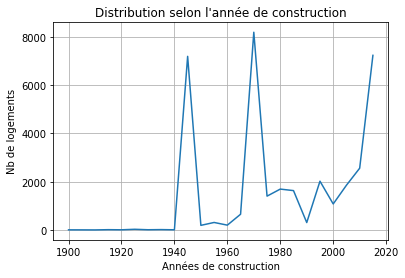

time: 782 ms (started: 2022-02-16 08:39:22 +00:00)


In [86]:
fig, ax = plt.subplots()
# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

ax.plot(titi,toto)

ax.set(xlabel='Années de construction', ylabel='Nb de logements',
       title='Distribution selon l\'année de construction')
ax.grid()

plt.savefig('figsize_test1.png',dpi=200)

a = plt.show()

In [87]:
import pandas as pd
import json
import requests
from pathlib import Path
import numpy as np
import sys
import requests
import json
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

time: 8.77 ms (started: 2022-02-16 08:39:35 +00:00)


In [88]:
df2.drop(df2.loc[df2['annee_construction'] < 1900 ].index, inplace = True)

time: 52.8 ms (started: 2022-02-16 08:39:36 +00:00)


In [89]:
pivot=df2.pivot_table(index='annee_construction',columns='classe_consommation_energie',values='consommation_energie',aggfunc='count')

time: 22.5 ms (started: 2022-02-16 08:39:38 +00:00)


In [90]:
if sys.platform =='linux':
    path_d = Path('/mnt/d')
else:
    path_d = Path('D://')
data_dir = path_d/'data'/'dpe'/'upload'    

plot_dir = Path('.')/'plot'
plot_dir.mkdir(exist_ok=True,parents=True)

time: 3.54 ms (started: 2022-02-16 08:39:39 +00:00)


In [91]:
dpe_color_palette=sns.color_palette('RdYlGn',7)
dpe_color_palette.reverse()
dpe_color_palette.append((0.9,0.9,0.9))

time: 5.13 ms (started: 2022-02-16 08:39:40 +00:00)


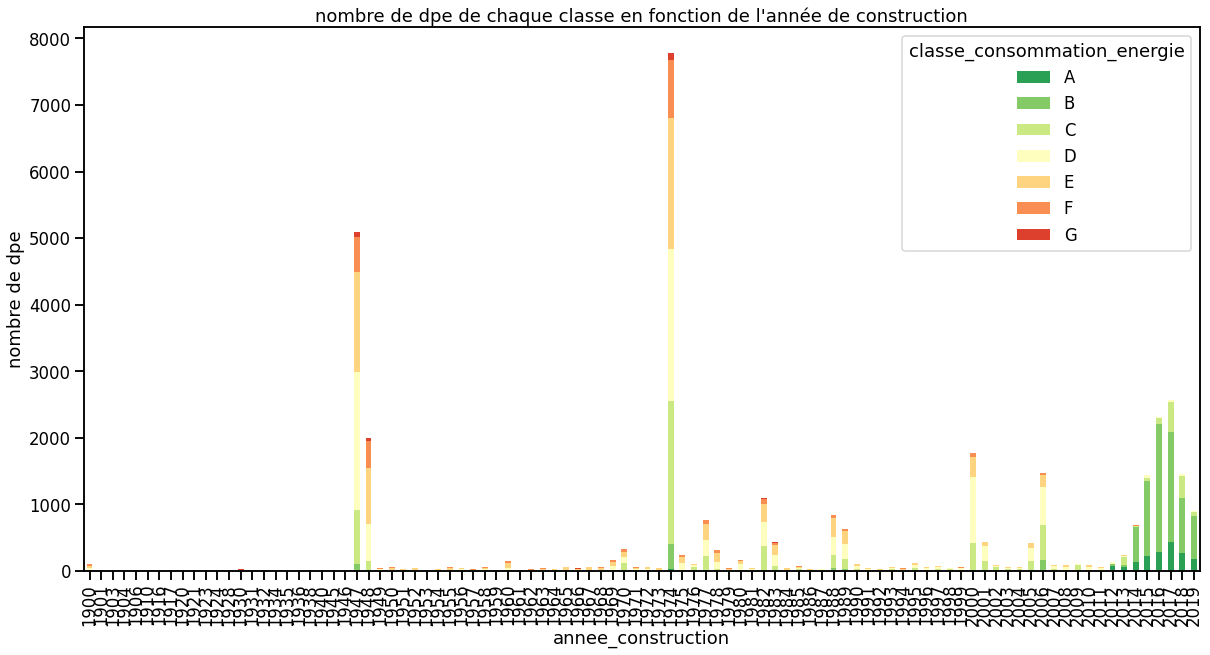

time: 4.52 s (started: 2022-02-16 08:39:41 +00:00)


In [92]:

ax=pivot.plot.bar(stacked=True,figsize=(20,10),color=dpe_color_palette)
ax.set_ylabel('nombre de dpe')
ax.set_title("nombre de dpe de chaque classe en fonction de l'année de construction")
plt.savefig(str(plot_dir/'etiquettes_vs_periodes.png'),bbox_inches='tight')



In [94]:
pivot3 = pd.crosstab(df2['annee_construction'],df2['classe_consommation_energie'],normalize='index')

time: 55.8 ms (started: 2022-02-16 08:40:30 +00:00)


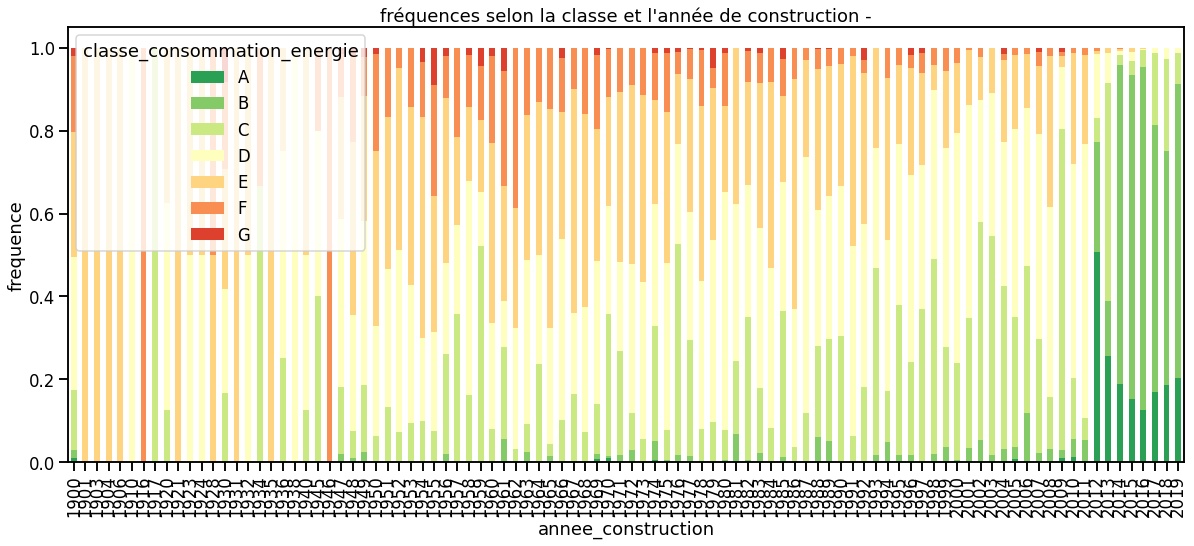

time: 10.1 s (started: 2022-02-16 08:40:31 +00:00)


In [95]:
ax=pivot3.plot.bar(stacked=True,figsize=(20,8),color=dpe_color_palette)
ax.set_ylabel('frequence')
ax.set_title("fréquences selon la classe et l'année de construction -")
plt.savefig(str(plot_dir/'etiquettes_vs_periodes.png'),bbox_inches='tight')

In [96]:
df2.groupby(pd.cut(df2['annee_construction'], np.arange(1900,2020,10)))['id'].count()

annee_construction
(1900, 1910]       5
(1910, 1920]      10
(1920, 1930]      31
(1930, 1940]      20
(1940, 1950]    7202
(1950, 1960]     498
(1960, 1970]     848
(1970, 1980]    9598
(1980, 1990]    3323
(1990, 2000]    2325
(2000, 2010]    2930
Name: id, dtype: int64

time: 19 ms (started: 2022-02-16 08:41:29 +00:00)


In [ ]:
#colonnes = ['longitude','latitude','classe_consommation_energie','concat-adress','date_etablissement_dpe','classe_estimation_ges','nom_rue','batiment','nom_rue']
#que l'on utilise en paramètre dans .loc[]#pour la même restruction que précédemment
#print(df2.loc[(df2['consommation_energie'] < 0),colonnes])

time: 1.49 ms (started: 2022-02-06 10:37:15 +00:00)


In [97]:
df2['tr002_type_batiment_id']

1        2
2        2
4        2
5        2
6        2
        ..
43657    1
43658    1
43659    1
43660    1
43661    1
Name: tr002_type_batiment_id, Length: 36691, dtype: int64

time: 11.1 ms (started: 2022-02-16 08:41:34 +00:00)


In [98]:
ds = pd.read_csv("/content/drive/MyDrive/Colab/76/76/td006_batiment.csv")

time: 681 ms (started: 2022-02-16 08:41:35 +00:00)


In [99]:
ds.columns

Index(['id', 'td001_dpe_id', 'besoin_chauffage', 'deperdition_enveloppe',
       'deperdition_renouvellement_air', 'tv014_permeabilite_id',
       'tv015_valeur_conventionnelle_renouvellement_air_id',
       'tv026_classe_inertie_id', 'altitude', 'nombre_niveau', 'hsp_moyenne',
       'nombre_appartements', 'cclim', 'comclim'],
      dtype='object')

time: 4.05 ms (started: 2022-02-16 08:41:37 +00:00)


In [100]:
dz = pd.read_csv("/content/drive/MyDrive/Colab/tables-references/tr002_type_batiment.csv")

time: 427 ms (started: 2022-02-16 08:41:38 +00:00)


In [101]:
dz.columns

Index(['id', 'code', 'description', 'libelle', 'est_efface', 'ordre',
       'simulateur'],
      dtype='object')

time: 4.47 ms (started: 2022-02-16 08:41:39 +00:00)


In [102]:
dz.head(5)

id       code  ... ordre simulateur
0   1  TR002_001  ...     1          1
1   2  TR002_002  ...     2          1
2   3  TR002_003  ...     3          0
3   4  TR002_004  ...     5          0
4   5  TR002_005  ...     4          0

[5 rows x 7 columns]

time: 20.9 ms (started: 2022-02-16 08:41:40 +00:00)


In [103]:
df2['tr002_type_batiment_id']

1        2
2        2
4        2
5        2
6        2
        ..
43657    1
43658    1
43659    1
43660    1
43661    1
Name: tr002_type_batiment_id, Length: 36691, dtype: int64

time: 5.85 ms (started: 2022-02-16 08:41:41 +00:00)


In [104]:
dz.rename(columns = {'id': 'tr002_type_batiment_id'},inplace = True ) 

time: 1.84 ms (started: 2022-02-16 08:41:42 +00:00)


In [105]:
df2.shape

(36691, 58)

time: 3.41 ms (started: 2022-02-16 08:41:43 +00:00)


In [106]:
df2 = pd.merge(df2, dz)  
print(df2.shape)

(36691, 63)
time: 179 ms (started: 2022-02-16 08:41:44 +00:00)


In [107]:
df2.columns

Index(['id', 'numero_dpe', 'usr_diagnostiqueur_id', 'usr_logiciel_id',
       'tr001_modele_dpe_id', 'nom_methode_dpe', 'version_methode_dpe',
       'date_visite_diagnostiqueur', 'date_etablissement_dpe',
       'date_arrete_tarifs_energies', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'tr002_type_batiment_id', 'annee_construction',
       'surface_habitable', 'surface_thermique_lot', 'tv016_departement_id',
       'commune', 'arrondissement', 'nom_rue', 'code_postal',
       'code_insee_commune', 'code_insee_commune_actualise',
       'portee_dpe_batiment', 'shon', 'surface_utile',
       'surface_thermique_parties_communes', 'en_souterrain', 'en_surface',
       'nombre_niveaux', 'nombre_circulations_verticales', 'nombre_boutiques',
       'presence_verriere', 'surface_verriere', 'nombre_entrees_avec_sas',
       'nombre_entrees_sans_sas', 'surface_baies_orientees_nord',
       'surface_baies_orientees_est_ouest', '

time: 5.39 ms (started: 2022-02-16 08:41:45 +00:00)


In [108]:
pivot4 = pd.crosstab(df2['description'],df2['classe_consommation_energie'],normalize='index')

time: 24.8 ms (started: 2022-02-16 08:41:46 +00:00)


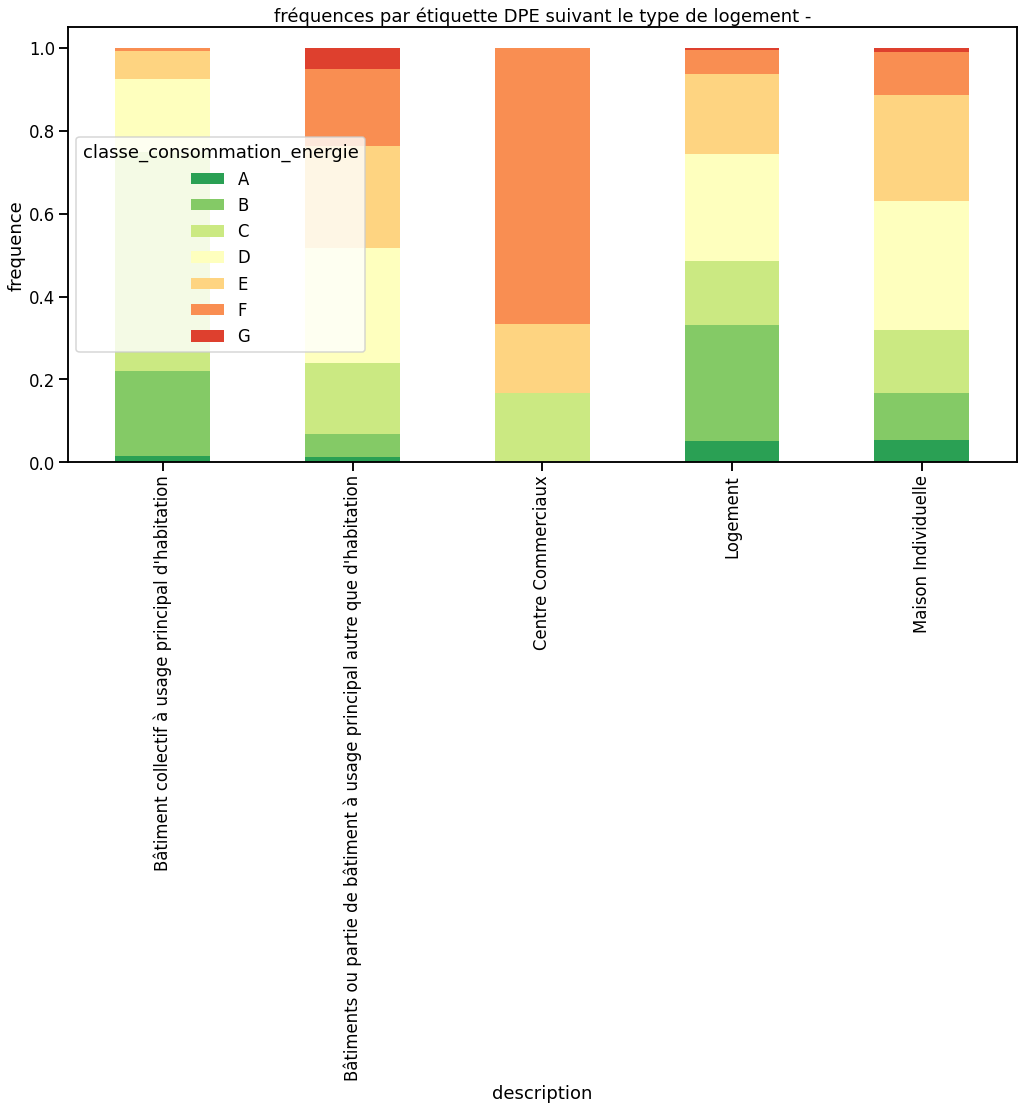

time: 779 ms (started: 2022-02-16 08:41:47 +00:00)


In [109]:
ax=pivot4.plot.bar(stacked=True,figsize=(17,8),color=dpe_color_palette)
ax.set_ylabel('frequence')
ax.set_title("fréquences par étiquette DPE suivant le type de logement -")
plt.savefig(str(plot_dir/'etiquettes_vs_periodes.png'),bbox_inches='tight')

In [ ]:
#pivot5 = pd.crosstab(df2['description'],df2['consommation_energie'],normalize='index')

time: 7.37 ms (started: 2022-02-06 10:47:39 +00:00)


In [110]:
pivot5 = df2.groupby("description")['consommation_energie'].mean()



time: 7.34 ms (started: 2022-02-16 08:42:17 +00:00)


In [111]:
pivot5

description
Bâtiment collectif à usage principal d'habitation                           131.479789
Bâtiments ou partie de bâtiment à usage principal autre que d'habitation    242.367037
Centre Commerciaux                                                          318.075000
Logement                                                                    166.685893
Maison Individuelle                                                         205.352153
Name: consommation_energie, dtype: float64

time: 3.99 ms (started: 2022-02-16 08:42:20 +00:00)


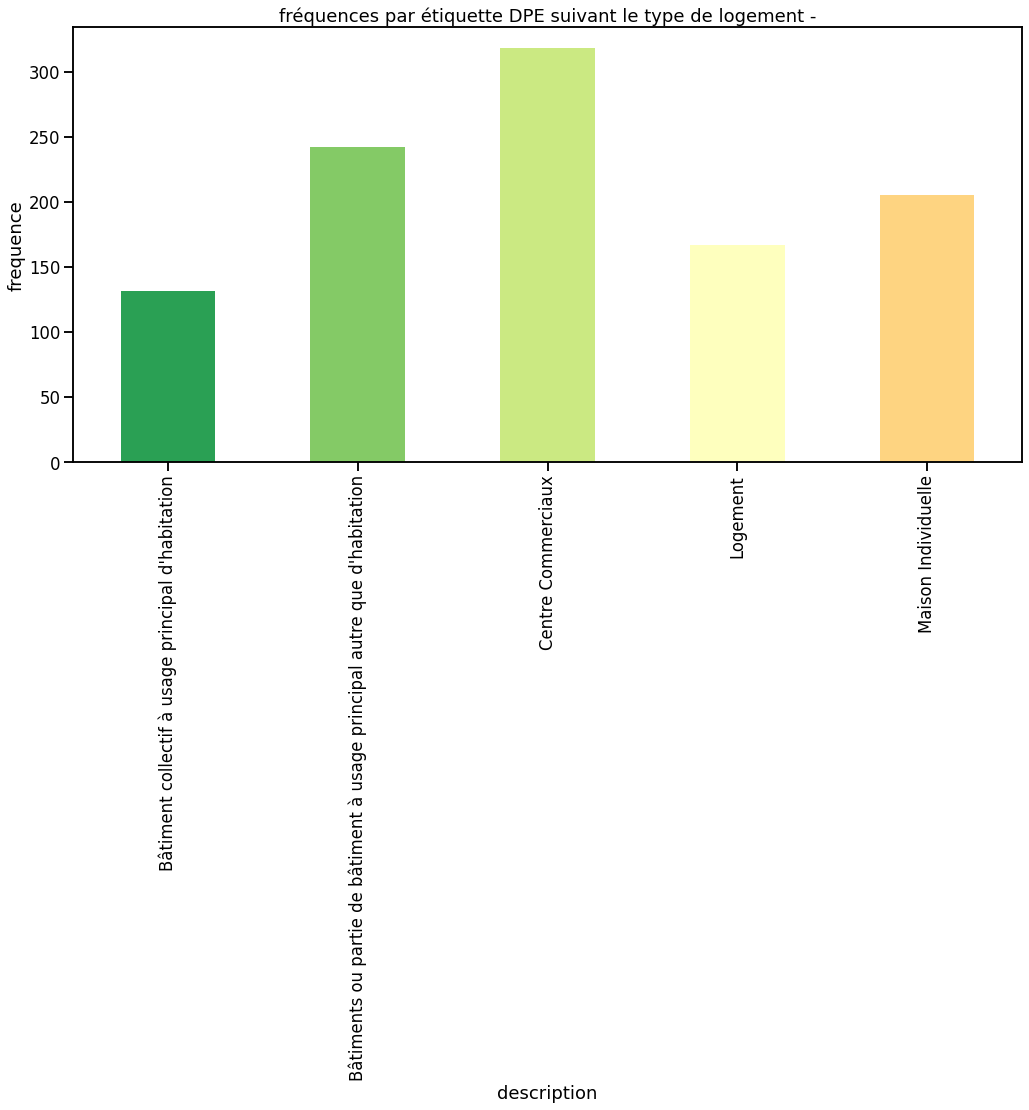

time: 775 ms (started: 2022-02-16 08:42:25 +00:00)


In [112]:
ax=pivot5.plot.bar(stacked=True,figsize=(17,8),color=dpe_color_palette)
ax.set_ylabel('frequence')
ax.set_title("fréquences par étiquette DPE suivant le type de logement -")
plt.savefig(str(plot_dir/'etiquettes_vs_periodes.png'),bbox_inches='tight')

In [113]:
dff.columns

Index(['id', 'numero_dpe', 'usr_diagnostiqueur_id', 'usr_logiciel_id',
       'tr001_modele_dpe_id', 'nom_methode_dpe', 'version_methode_dpe',
       'nom_methode_etude_thermique', 'version_methode_etude_thermique',
       'date_visite_diagnostiqueur', 'date_etablissement_dpe',
       'date_arrete_tarifs_energies',
       'commentaires_ameliorations_recommandations',
       'explication_personnalisee', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'tr002_type_batiment_id', 'secteur_activite',
       'tr012_categorie_erp_id', 'tr013_type_erp_id', 'annee_construction',
       'surface_habitable', 'surface_thermique_lot', 'tv016_departement_id',
       'commune', 'arrondissement', 'type_voie', 'nom_rue', 'numero_rue',
       'batiment', 'escalier', 'etage', 'porte', 'code_postal',
       'code_insee_commune', 'code_insee_commune_actualise', 'numero_lot',
       'surface_commerciale_contractuelle', 'portee_dpe_batiment',
   

time: 5.16 ms (started: 2022-02-16 08:43:44 +00:00)


In [ ]:
df2.to_csv('/content/drive/MyDrive/Colab/data/dpe_enriched1.csv')

time: 3.29 s (started: 2022-02-06 12:43:18 +00:00)


In [ ]:
df2.columns

Index(['id', 'numero_dpe', 'usr_diagnostiqueur_id', 'usr_logiciel_id',
       'tr001_modele_dpe_id', 'nom_methode_dpe', 'version_methode_dpe',
       'date_visite_diagnostiqueur', 'date_etablissement_dpe',
       'date_arrete_tarifs_energies', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'tr002_type_batiment_id', 'annee_construction',
       'surface_habitable', 'surface_thermique_lot', 'tv016_departement_id',
       'commune', 'arrondissement', 'nom_rue', 'code_postal',
       'code_insee_commune', 'code_insee_commune_actualise',
       'portee_dpe_batiment', 'shon', 'surface_utile',
       'surface_thermique_parties_communes', 'en_souterrain', 'en_surface',
       'nombre_niveaux', 'nombre_circulations_verticales', 'nombre_boutiques',
       'presence_verriere', 'surface_verriere', 'nombre_entrees_avec_sas',
       'nombre_entrees_sans_sas', 'surface_baies_orientees_nord',
       'surface_baies_orientees_est_ouest', '

time: 35 ms (started: 2022-02-06 12:52:51 +00:00)


In [ ]:
dss = pd.read_csv("/content/drive/MyDrive/Colab/data/dpe_enriched_2.csv")

time: 1.72 s (started: 2022-02-06 13:14:36 +00:00)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (1,22,24,25,26,29,30,33,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
dss.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'numero_dpe',
       'usr_diagnostiqueur_id', 'usr_logiciel_id', 'tr001_modele_dpe_id',
       'nom_methode_dpe', 'version_methode_dpe', 'date_visite_diagnostiqueur',
       'date_etablissement_dpe', 'date_arrete_tarifs_energies',
       'consommation_energie', 'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'tr002_type_batiment_id', 'annee_construction',
       'surface_habitable', 'surface_thermique_lot', 'code_departement',
       'commune', 'arrondissement', 'nom_rue', 'code_postal',
       'code_insee_commune', 'code_insee_commune_actualise',
       'portee_dpe_batiment', 'shon', 'surface_utile',
       'surface_thermique_parties_communes', 'en_souterrain', 'en_surface',
       'nombre_niveaux', 'nombre_circulations_verticales', 'nombre_boutiques',
       'presence_verriere', 'surface_verriere', 'nombre_entrees_avec_sas',
       'nombre_entrees_sans_sas', 'surface_baies_orientees_nord',
       'surface_bai

time: 13.8 ms (started: 2022-02-06 13:14:54 +00:00)


In [ ]:
dss['nom_methode_dpe'].unique()

array(['FACTURE - DPE', 'Méthode Facture', 'FACTURE', '3CL - DPE',
       'facture', 'FACTURES', 'DPE VIERGE', '3CL-DPE', 'FACTURE SEULE',
       'th-CE', 'factures', 'sur factures', 'Th-BCE', 'DPE FACTURES',
       'DPE 3CL 2012', 'Factures', 'Facture', 'TH_C_E', 'DPE factures',
       'TROIS_CL_DPE', 'Méthode 3CL', '3CL', '3CL 2012',
       'MIXTE FACTURE+3CL - DPE pour ECS', 'SUR FACTURES', '3CL2012',
       'DPE3CL', 'DPE 3CL', 'DPE3CL2012', 'DPE 3CL2012', 'DPE 2012 3CL',
       'DPE3CL 2012', 'Th-C-E', 'TH RT2012', 'TH C RT2012', 'TH_BCE',
       'TH BCE2012', 'TH CE 2012', 'SUR FACTURE', 'TH BAT 2012',
       'TH-CE 2012', '63.8', '62.5', '63.3', '63.0', '63.1', '65.0',
       '66.8', '67.7', '72.0', '76.2', '76.3', '59.1', '76.05', '66.7',
       '65.3', '71.7', '84.1', '57.4', '39.9', '40.6', '48.1', '48.2'],
      dtype=object)

time: 29.7 ms (started: 2022-02-06 13:15:41 +00:00)


In [ ]:
df2['nom_methode_dpe'].unique()

array(['FACTURE - DPE', 'Méthode Facture', 'FACTURE', '3CL - DPE',
       'facture', 'FACTURES', 'DPE VIERGE', '3CL-DPE', 'FACTURE SEULE',
       'th-CE', 'factures', 'sur factures', 'Th-BCE', 'DPE FACTURES',
       'DPE 3CL 2012', 'Factures', 'Facture', 'TH_C_E', 'DPE factures',
       'TROIS_CL_DPE', 'Méthode 3CL', '3CL', '3CL 2012',
       'MIXTE FACTURE+3CL - DPE pour ECS', 'SUR FACTURES', '3CL2012',
       'DPE3CL', 'DPE 3CL', 'DPE3CL2012', 'DPE 3CL2012', 'DPE 2012 3CL',
       'DPE3CL 2012', 'Th-C-E', 'TH RT2012', 'TH C RT2012', 'TH_BCE',
       'TH BCE2012', 'TH CE 2012', 'SUR FACTURE', 'TH BAT 2012',
       'TH-CE 2012'], dtype=object)

time: 23.6 ms (started: 2022-02-06 13:16:03 +00:00)
